# RL Trading based on RNN

In [111]:
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [112]:
# def setup_seed(seed):
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     np.random.seed(seed)
#     random.seed(seed)
#     torch.backends.cudnn.deterministic = True
# # 设置随机数种子
# setup_seed(20)

## 1. Loading data and data preprocessing

In [113]:
raw_prices = pd.read_csv("BTC.csv", header=None)
prices = np.array(raw_prices[1])
OFFSET = 200 #数据起始点
M = 20  #输入网络的历史窗口的大小，用于在每个时间步更新权重的历史大小,r的系数个数
T = 2000 #交易者输入的时间序列长度
N = 600  #验证集大小
prices = prices[OFFSET:OFFSET+M+T+N+1]
# asset_returns = torch.tensor(np.log(prices[1:]) - np.log(prices[:-1])).to(torch.float32)
asset_returns = torch.tensor(prices[1:] - prices[:-1]).to(torch.float32)
print('asset_returns',asset_returns)
scaler = StandardScaler()
normalized_asset_returns = torch.tensor(scaler.fit_transform(asset_returns[:M+T][:, None])[:, 0]).to(torch.float32)

asset_returns tensor([-1.6900e+00, -6.6000e-01, -2.1400e+00,  ..., -1.0181e+03,
        -4.4164e+03, -2.1501e+03])


## 2. Create NN model

In [114]:
class RRL(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RRL, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        out, (hn) = self.rnn(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        return torch.tanh(out)

In [115]:
input_dim = 1
hidden_dim = 64
num_layers = 3
output_dim = 1
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")
model = RRL(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
print(model)

RRL(
  (rnn): RNN(1, 64, num_layers=3, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


## 3. Train the model

In [116]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
rewards = []
max_iter = 1000
miu = 1
delta = 0.04
eps = 1e-6

In [117]:
for epoch in range(max_iter):
    optimizer.zero_grad()
    Ft = torch.zeros(T).to(normalized_asset_returns.device)
    for i in range(1, T):
        data = normalized_asset_returns[i-1:i+M-1]
        input = data.view(1,M,1).to(device)
        Ft[i] = model(input)
    returns = miu * (Ft[:T-1] * asset_returns[M:M+T-1]) - (delta * torch.abs(Ft[1:] - Ft[:T-1]))
    expected_return = torch.mean(returns, dim=-1)
    std_return = torch.std(returns, dim=-1)
    sharpe = expected_return / (torch.sqrt(std_return) + eps)
    (-1 * sharpe).backward()
    optimizer.step()
    rewards.append(sharpe.detach().cpu())
    Cum_return_train = returns.cumsum(dim=-1)
    print("Epoch ", epoch, "Sharpe: ", sharpe.detach().cpu())
# print('Cum_return_train',Cum_returns[-1])

Epoch  0 Sharpe:  tensor(-0.0943)
Epoch  1 Sharpe:  tensor(0.0853)
Epoch  2 Sharpe:  tensor(0.2348)
Epoch  3 Sharpe:  tensor(0.3120)
Epoch  4 Sharpe:  tensor(0.3711)
Epoch  5 Sharpe:  tensor(0.4260)
Epoch  6 Sharpe:  tensor(0.4800)
Epoch  7 Sharpe:  tensor(0.5331)
Epoch  8 Sharpe:  tensor(0.5850)
Epoch  9 Sharpe:  tensor(0.6364)
Epoch  10 Sharpe:  tensor(0.6897)
Epoch  11 Sharpe:  tensor(0.7480)
Epoch  12 Sharpe:  tensor(0.8132)
Epoch  13 Sharpe:  tensor(0.8823)
Epoch  14 Sharpe:  tensor(0.9471)
Epoch  15 Sharpe:  tensor(0.9992)
Epoch  16 Sharpe:  tensor(1.0374)
Epoch  17 Sharpe:  tensor(1.0664)
Epoch  18 Sharpe:  tensor(1.0923)
Epoch  19 Sharpe:  tensor(1.1186)
Epoch  20 Sharpe:  tensor(1.1457)
Epoch  21 Sharpe:  tensor(1.1718)
Epoch  22 Sharpe:  tensor(1.1951)
Epoch  23 Sharpe:  tensor(1.2147)
Epoch  24 Sharpe:  tensor(1.2315)
Epoch  25 Sharpe:  tensor(1.2469)
Epoch  26 Sharpe:  tensor(1.2622)
Epoch  27 Sharpe:  tensor(1.2786)
Epoch  28 Sharpe:  tensor(1.2957)
Epoch  29 Sharpe:  tens

## 4. Visualization

Cum_return_train tensor(78243.8672, grad_fn=<SelectBackward>)


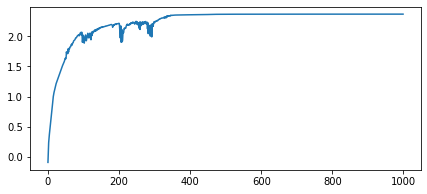

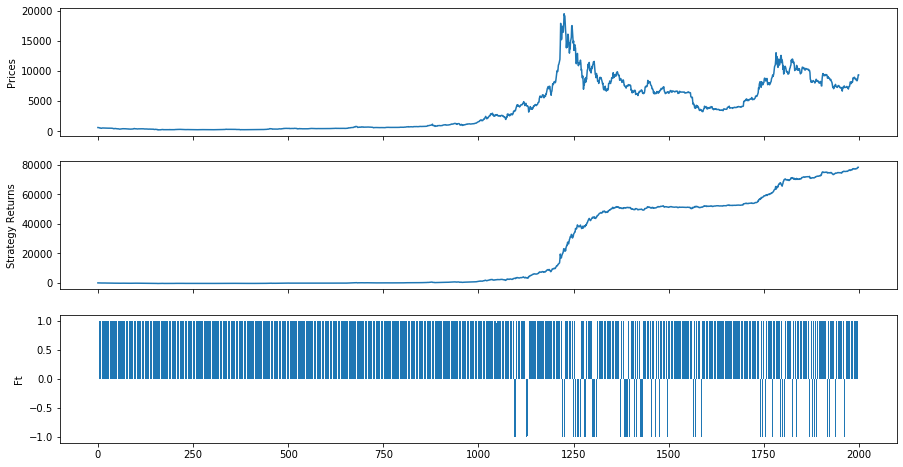

In [118]:
print('Cum_return_train',Cum_return_train[-1])
plt.rcParams['figure.figsize'] = [7, 3]
# plt.title("sharp's ratio optimization RRL")
plt.plot(rewards)
# plt.ylim((-0.5,0.5))
# plt.legend(['sharp\'s ratio(RRL):M=10,layer=3'],loc='upper left')
plt.savefig("SRRRL20-3.png", dpi=300)
plt.show()

plt.rcParams['figure.figsize'] = [15, 8]
f, axes = plt.subplots(3, 1, sharex=True)
# plt.suptitle("BTC RRL Train", fontsize=16)

axes[0].set_ylabel("Prices")
axes[0].plot(prices[M:M+T])
axes[1].set_ylabel("Strategy Returns")
axes[1].plot(Cum_return_train.detach().numpy())
axes[2].set_ylabel("Ft")
axes[2].bar(list(range(len(Cum_return_train))), Ft[:-1].detach().numpy())
# plt.legend(['Train(RRL):M=10,layer=3'],loc='upper left')
plt.savefig("TrainRRL20-3.png", dpi=300)
plt.show()

In [119]:
# data:M+T:M+T+N+1
prices_test = np.array(raw_prices[1])[OFFSET+M+T:]
asset_returns_test = asset_returns[:M+N+1]
scaler = StandardScaler()
normalized_asset_returns_test = torch.tensor(scaler.fit_transform(asset_returns_test[:M+N+1][:, None])[:, 0]).to(torch.float32)
# normalized_asset_returns_test = normalized_asset_returns[M+T:T+M+N+1]
# print(asset_returns_test,normalized_asset_returns_test)

rewards_test = []
Ft_test = torch.zeros(N).to(normalized_asset_returns_test.device)
for i in range(1, N):
    data_test = normalized_asset_returns_test[i-1:i+M-1]
    input_test = data_test.view(1,M,1).to(device)
    Ft_test[i] = model(input_test)
    returns_test = miu * (Ft_test[:N-1] * asset_returns_test[M:M+N-1]) - (delta * torch.abs(Ft_test[1:] - Ft_test[:N-1]))
    expected_return_test = torch.mean(returns_test, dim=-1)
    std_return_test = torch.std(returns_test, dim=-1)
    sharpe_test = expected_return_test / (torch.sqrt(std_return_test) + eps)
    rewards_test.append(sharpe_test.detach().cpu())
    Cum_return_tests = returns_test.cumsum(dim=-1)
# print('rewards_test',rewards_test)
print('Cum_return_test',Cum_return_tests[-1])

Cum_return_test tensor(-385.9592, grad_fn=<SelectBackward>)


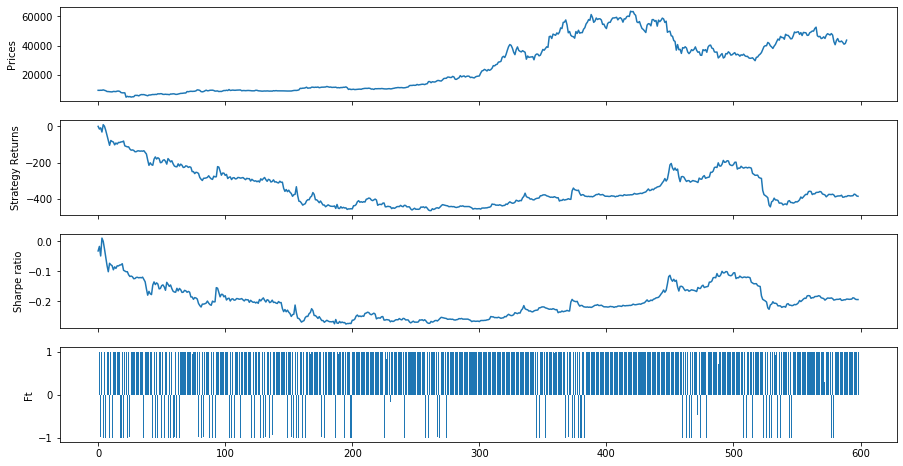

In [120]:
plt.rcParams['figure.figsize'] = [15, 8]
f, axes = plt.subplots(4, 1, sharex=True)
axes[0].set_ylabel("Prices")
axes[0].plot(prices_test[M:M+N+1])
axes[1].set_ylabel("Strategy Returns")
axes[1].plot(Cum_return_tests.detach().numpy())
axes[2].set_ylabel("Sharpe ratio")
axes[2].plot(rewards_test)
axes[3].set_ylabel("Ft")
axes[3].bar(list(range(len(Cum_return_tests))), Ft_test[:-1].detach().numpy())
plt.savefig("TestRRL20-3.png", dpi=300)
plt.show()